**Dataset**: [MovieLens Dataset](http://grouplens.org/datasets/movielens/) from grouplens.org.

**Task**: To build a recommender system using [AutoEncoders](http://en.wikipedia.org/wiki/Autoencoder).

In [1]:
## package imports

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

import matplotlib.pyplot as plt

In [2]:
## data import

train = pd.read_csv('ml-100k/u1.base', sep='\t', header=None)
test = pd.read_csv('ml-100k/u1.test', sep='\t', header=None)

In [3]:
train.head()

,0,1,2,3
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [4]:
test.head()

,0,1,2,3
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


**Important**: Columns '0', '1', '2', and '3', represent users, movies, ratings, and timestamps respectively.

In [5]:
## converting train and test sets into arrays

train = np.array(train, dtype=int)
test = np.array(test, dtype=int)

## getting number of users and movies

num_users = int(max(max(train[:,0]), max(test[:,0])))
num_movies = int(max(max(train[:,1]), max(test[:,1])))

In [6]:
num_users

943

In [7]:
num_movies

1682

In [8]:
## coverting datasets into a list of lists of dimension (num_users, num_movies) for pytorch tensor compatibility

def convert(data): ## function to convert
    
    final_list = list() ## initialization
    
    for user_id in range(1, num_users + 1):
        
        user_movies = data[:,1][data[:,0]==user_id] ## all movies rated by user
        user_ratings = data[:,2][data[:,0]==user_id] ## all ratings by user
        
        user_all_movies = np.zeros(num_movies) ## user ratings for each movie. 0 for urated morvies.
        user_all_movies[user_movies-1] = user_ratings
            
        final_list.append(user_all_movies)
    
    return final_list

train, test = convert(train), convert(test) ## data format conversion

In [9]:
train[0]

array([5., 3., 4., ..., 0., 0., 0.])

In [10]:
test[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
## converting into pytorch tensors of dimensions (num_users, num_movies)

train = torch.FloatTensor(train)
test = torch.FloatTensor(test)

C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
train

tensor([[5., 3., 4.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.]])

In [13]:
test

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [14]:
train.shape

torch.Size([943, 1682])

In [15]:
test.shape

torch.Size([943, 1682])

In [16]:
## creating autoencoder architecture

## creating a class

class StackedAutoEncoder(torch.nn.Module): ## inheriting methods and functions from the nn.Module class
    
    def __init__(self): ## neurons --> list of neurons for the three layers of the SAE in format (l1, l2, l3)
        
        super(StackedAutoEncoder, self).__init__() ## to inherit from the parent class
        
        self.fc1 = torch.nn.Linear(in_features=num_movies, out_features=40) ## first full connection
        
        self.fc2 = torch.nn.Linear(in_features=40, out_features=20) ## second full connection
        
        self.fc3 = torch.nn.Linear(in_features=20, out_features=40) ## third full connection
        
        self.fc4 = torch.nn.Linear(in_features=40, out_features=num_movies) ## fourth full connection
        
        self.activation = torch.nn.Tanh() ## specifying hyperbolic tangent as activation for the three hidden layers
        
        
    ## function for forward propagation
    
    def forward(self, x): ## x --> input vector
        
        x = self.activation(self.fc1(x)) ## encoding one, (num_movies --> 40)
        
        x = self.activation(self.fc2(x)) ## encoding two, (40 --> 20)
        
        x = self.activation(self.fc3(x)) ## decoding one, (20 --> 40)
        
        x = self.fc4(x) ## decoding two, (40 --> num_movies), no activation function for output layer
        
        return x

In [17]:
## creating object of StackedAutoEncoder class

sae = StackedAutoEncoder()

criterion = nn.MSELoss() ## mean squared error

optimizer = optim.RMSprop(params=sae.parameters(), lr=0.01, weight_decay=0.5)

In [18]:
## training the auto encoder

epochs = 200

train_loss_list = list() ## to collect value of loss over epochs

for epoch in range(1, epochs+1):
    
    train_loss = 0
    
    counter = 0. ## to count observations containing atleast one rating
    
    for user_id in range(num_users):
        
        inpt = torch.autograd.Variable(train[[user_id]]) ## pytorch requires multidimensional vectors as inputs
        
        target = inpt.clone() ## remains unchanged, used for evaluation and back propagation
        
        if torch.sum(target.data > 0) > 0: ## filter observations with no ratings to save memory
            
            output = sae.forward(inpt) ## forward propagation
            
            target.require_grad = False ## target not used for gradient optimization to save memory
            
            output[target == 0] = 0 ## setting indices representing unrated movies back to 0 to avoid error
            
            loss = criterion(output, target)
            
            mean_corrector = num_movies/float(torch.sum(target.data > 0) + 1e-100) ## helps adjust mse for only rated movies
            
            loss.backward() ## fetch direction for weight optimization
            
            train_loss += np.sqrt(loss.data.item()*mean_corrector) ## update train loss with corrected MSE and sqrt to get RMSE
            
            counter += 1.
            
            optimizer.step() ## fetch magnitude for weight optimization
    
    train_loss_list.append(train_loss/counter)
            
    print(f"epoch: {epoch:<{7}} train_loss: {train_loss/counter}")

epoch: 1       train_loss: 1.9409408840146465
epoch: 2       train_loss: 1.0812986893733467
epoch: 3       train_loss: 1.0584797202449872
epoch: 4       train_loss: 1.0503639053937657
epoch: 5       train_loss: 1.0496793104903426
epoch: 6       train_loss: 1.0467643640707966
epoch: 7       train_loss: 1.0446166693069898
epoch: 8       train_loss: 1.0431896098518425
epoch: 9       train_loss: 1.041605496781001
epoch: 10      train_loss: 1.039868172597204
epoch: 11      train_loss: 1.0398578010341974
epoch: 12      train_loss: 1.0385515872698505
epoch: 13      train_loss: 1.0380546859755901
epoch: 14      train_loss: 1.0365259269246376
epoch: 15      train_loss: 1.0359406209514108
epoch: 16      train_loss: 1.0357289807992263
epoch: 17      train_loss: 1.0359037947003118
epoch: 18      train_loss: 1.0349561815606771
epoch: 19      train_loss: 1.0335923460765462
epoch: 20      train_loss: 1.0319299728997435
epoch: 21      train_loss: 1.0296383041430932
epoch: 22      train_loss: 1.0245528

epoch: 180     train_loss: 0.8833625748404588
epoch: 181     train_loss: 0.8781487627925684
epoch: 182     train_loss: 0.875884688272722
epoch: 183     train_loss: 0.8721453169386936
epoch: 184     train_loss: 0.8690907020006003
epoch: 185     train_loss: 0.8689939502933893
epoch: 186     train_loss: 0.8667575647104216
epoch: 187     train_loss: 0.8653124380516461
epoch: 188     train_loss: 0.8694993541252302
epoch: 189     train_loss: 0.8662848978712476
epoch: 190     train_loss: 0.8651984906978828
epoch: 191     train_loss: 0.8629886685300461
epoch: 192     train_loss: 0.8613548281141752
epoch: 193     train_loss: 0.8615385436128824
epoch: 194     train_loss: 0.860918200371808
epoch: 195     train_loss: 0.8618191373426015
epoch: 196     train_loss: 0.8600129223263995
epoch: 197     train_loss: 0.8577229403441412
epoch: 198     train_loss: 0.8556638204578686
epoch: 199     train_loss: 0.8610906211459529
epoch: 200     train_loss: 0.8708069117143478


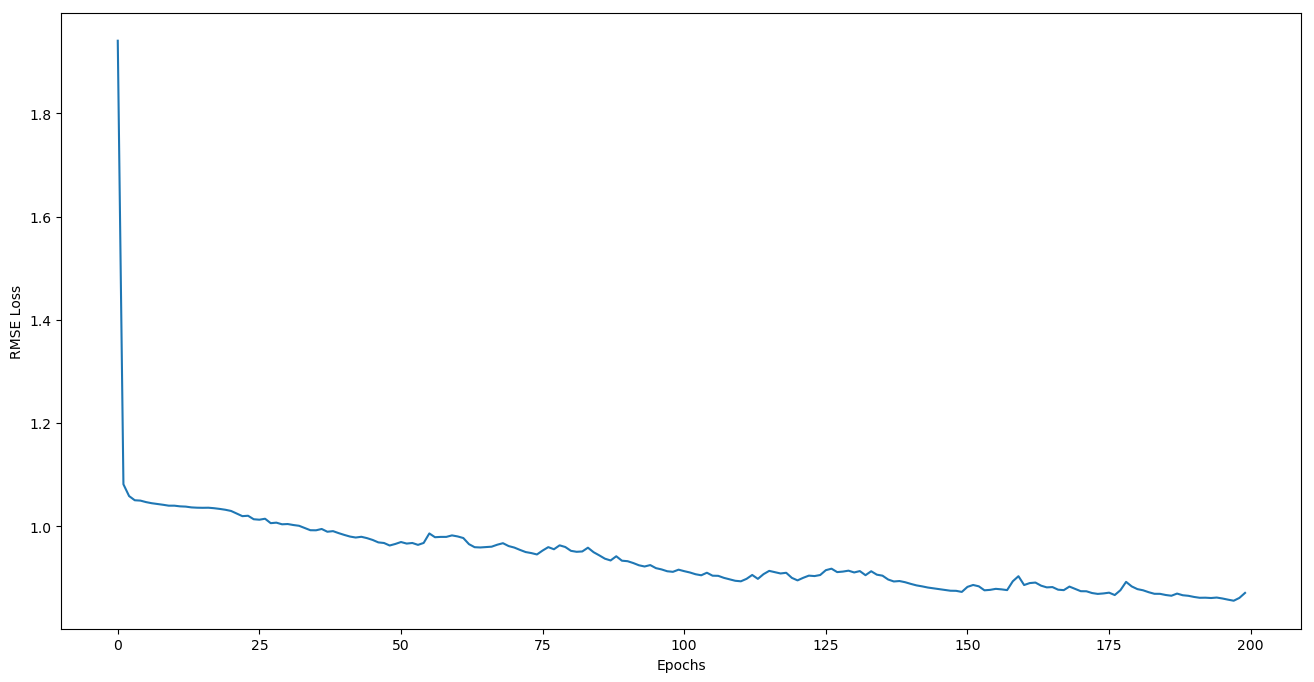

In [19]:
## plot of loss over epochs

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(train_loss_list)
ax.set_xlabel('Epochs')
ax.set_ylabel('RMSE Loss')

plt.show()

In [20]:
test_loss = 0
    
counter = 0. ## to count observations containing atleast one rating
    
for user_id in range(num_users):
        
    inpt = torch.autograd.Variable(train[[user_id]]) ## VERY IMPORTANT --> why train?
        
    target = torch.autograd.Variable(test[[user_id]])
        
    if torch.sum(target.data > 0) > 0: ## filter observations with no ratings to save memory
            
        output = sae.forward(inpt) ## forward propagation
            
        target.require_grad = False ## target not used for gradient optimization to save memory
            
        output[target == 0] = 0 ## setting indices representing unrated movies back to 0 to avoid error
            
        loss = criterion(output, target)
            
        mean_corrector = num_movies/float(torch.sum(target.data > 0) + 1e-100) ## helps adjust mse for only rated movies
            
        test_loss += np.sqrt(loss.data.item()*mean_corrector) ## update train loss with corrected MSE and sqrt to get RMSE
            
        counter += 1.
                    
print(f"test_loss: {test_loss/counter}")

test_loss: 1.060441858531912
